In [115]:
%load_ext autoreload
from ddls.plotting.plotting import PlotAesthetics
from ddls.environments.ramp_cluster.ramp_cluster_environment import RampClusterEnvironment
from ddls.environments.ramp_cluster.utils import load_ramp_cluster_environment_metrics
from ddls.utils import map_agent_id_to_hparams

from collections import defaultdict
from sqlitedict import SqliteDict
import pprint
import glob
import os
import time
import pandas as pd
import numpy as np
import scipy.stats as st
import sigfig

import gzip
import pickle

from omegaconf import OmegaConf
from functools import reduce

import matplotlib.pyplot as plt
import seaborn as sns

from IPython.display import display

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [137]:
%autoreload
base_folder = '/scratch/datasets/ddls/sims/'

# base_name = 'ramp_job_placement_shaping'
base_name = 'ramp_job_partitioning'

In [159]:
%autoreload
# useful tool for mapping IDs to params so you know what agent label to map to which ID

# ids = [i for i in range(1207, 1219)] # interarrival time = 500-16000
# ids = [i for i in range(1219, 1229)] # interarrival time = 2000-4000
# ids = [i for i in range(1237, 1267)] # interarrival time = 2000-4000, seed = 0-2, shuffle=True
# ids = [i for i in range(1267, 1285)] # interarrival time = 2000-4000, shuffle=True
# ids = [i for i in range(1337, 1392)] # interarrival time = 2000-4000, shuffle=True 
ids = [i for i in range(1337, 1391)] # interarrival time = 2000-4000, shuffle=True 

print(f'Mapping IDs {ids}')

# map IDs to parameters you want to look at
hparams = [
            'eval_loop.actor._target_',
            'eval_loop.env.jobs_config.job_interarrival_time_dist.val',
            'experiment.seed'
          ]
_ = map_agent_id_to_hparams(base_folder=base_folder, base_name=base_name, ids=ids, hparams=hparams, verbose=True)

Mapping IDs [1337, 1338, 1339, 1340, 1341, 1342, 1343, 1344, 1345, 1346, 1347, 1348, 1349, 1350, 1351, 1352, 1353, 1354, 1355, 1356, 1357, 1358, 1359, 1360, 1361, 1362, 1363, 1364, 1365, 1366, 1367, 1368, 1369, 1370, 1371, 1372, 1373, 1374, 1375, 1376, 1377, 1378, 1379, 1380, 1381, 1382, 1383, 1384, 1385, 1386, 1387, 1388, 1389, 1390]

Loaded config for ID 1337 from /scratch/datasets/ddls/sims//ramp_job_partitioning/ramp_job_partitioning_1337/heuristic_config.yaml
ID 1337 has hparam eval_loop.actor._target_ value ddls.environments.ramp_job_partitioning.agents.no_parallelism.NoParallelism
ID 1337 has hparam eval_loop.env.jobs_config.job_interarrival_time_dist.val value 2000
ID 1337 has hparam experiment.seed value 0

Loaded config for ID 1338 from /scratch/datasets/ddls/sims//ramp_job_partitioning/ramp_job_partitioning_1338/heuristic_config.yaml
ID 1338 has hparam eval_loop.actor._target_ value ddls.environments.ramp_job_partitioning.agents.no_parallelism.NoParallelism
ID 1338 has hpara

In [160]:
%autoreload
# set agent label to ID mapping

agent_to_id = {
    
    # NoPara vs. SiP-ML diff loads -> throughput inadequacy
    # # interarrival time = 500-16000
    # 'Sequential': [1207, 1208, 1209, 1210, 1211, 1212],
    # 'SiP-ML': [1213, 1214, 1215, 1216, 1217, 1218],
    # interarrival time = 2000-4000
    # 'Sequential': [1219, 1220, 1221, 1222, 1223],
    # 'SiP-ML': [1224, 1225, 1226, 1227, 1228],
    # 'Sequential': [i for i in range(1237, 1252)],
    # 'SiP-ML': [i for i in range(1252, 1267)],
    # 'Sequential': [i for i in range(1267, 1276)],
    # 'SiP-ML': [i for i in range(1276, 1285)],
    'Sequential': [i for i in range(1337, 1364)],
    'SiP-ML': [i for i in range(1364, 1391)],
    
    # 'RL\n(Acc)': f'{base_folder}/{base_name}/{base_name}_{103}/checkpoints/checkpoint_000500/',
}

# load data
data = load_ramp_cluster_environment_metrics(base_folder=base_folder, base_name=base_name, ids=ids, agent_to_id=agent_to_id)

# unpack dicts
agent_to_episode_stats_dict, agent_to_episode_completion_stats_dict, agent_to_episode_blocked_stats_dict, agent_to_step_stats_dict = data

# convert dicts to dataframes
print(f'\nEpisode stats:')
episode_stats_df = pd.DataFrame(agent_to_episode_stats_dict)
display(episode_stats_df)

episode_completion_stats_df = pd.DataFrame(agent_to_episode_completion_stats_dict)
display(episode_completion_stats_df)

episode_blocked_stats_df = pd.DataFrame(agent_to_episode_blocked_stats_dict)
display(episode_blocked_stats_df)

print(f'\nStep stats:')
step_stats_df = pd.DataFrame(agent_to_step_stats_dict)
display(step_stats_df)


Loading validation data from /scratch/datasets/ddls/sims/ramp_job_partitioning/ramp_job_partitioning_1337...
Checkpoints loaded from /scratch/datasets/ddls/sims/ramp_job_partitioning/ramp_job_partitioning_1337.

Loading validation data from /scratch/datasets/ddls/sims/ramp_job_partitioning/ramp_job_partitioning_1338...
Checkpoints loaded from /scratch/datasets/ddls/sims/ramp_job_partitioning/ramp_job_partitioning_1338.

Loading validation data from /scratch/datasets/ddls/sims/ramp_job_partitioning/ramp_job_partitioning_1339...
Checkpoints loaded from /scratch/datasets/ddls/sims/ramp_job_partitioning/ramp_job_partitioning_1339.

Loading validation data from /scratch/datasets/ddls/sims/ramp_job_partitioning/ramp_job_partitioning_1340...
Checkpoints loaded from /scratch/datasets/ddls/sims/ramp_job_partitioning/ramp_job_partitioning_1340.

Loading validation data from /scratch/datasets/ddls/sims/ramp_job_partitioning/ramp_job_partitioning_1341...
Checkpoints loaded from /scratch/datasets/

,num_jobs_arrived,num_jobs_completed,num_jobs_blocked,episode_start_time,compute_info_processed,dep_info_processed,flow_info_processed,cluster_info_processed,demand_compute_info_processed,demand_dep_info_processed,...,acceptance_rate,mean_compute_throughput,mean_dep_throughput,mean_flow_throughput,mean_cluster_throughput,mean_demand_compute_throughput,mean_demand_dep_throughput,mean_demand_total_throughput,return,Agent
0,501.0,382.0,118.0,0.0,6.088491e+12,6.450189e+12,0.000000e+00,1.253868e+13,6.088491e+12,6.071086e+12,...,0.762475,6.088491e+06,6.450189e+06,0.000000e+00,1.253868e+07,6.088491e+06,6.071086e+06,1.215958e+07,284,Sequential
1,501.0,396.0,104.0,0.0,6.107933e+12,6.439598e+12,0.000000e+00,1.254753e+13,6.107933e+12,6.034637e+12,...,0.790419,6.107933e+06,6.439598e+06,0.000000e+00,1.254753e+07,6.107933e+06,6.034637e+06,1.214257e+07,314,Sequential
2,501.0,377.0,123.0,0.0,5.876633e+12,6.231091e+12,0.000000e+00,1.210772e+13,5.876633e+12,5.861787e+12,...,0.752495,5.876633e+06,6.231091e+06,0.000000e+00,1.210772e+07,5.876633e+06,5.861787e+06,1.173842e+07,276,Sequential
3,445.0,339.0,106.0,0.0,5.112503e+12,5.423107e+12,0.000000e+00,1.053561e+13,5.112503e+12,5.077073e+12,...,0.761798,5.112503e+06,5.423107e+06,0.000000e+00,1.053561e+07,5.112503e+06,5.077073e+06,1.018958e+07,253,Sequential
4,445.0,357.0,88.0,0.0,5.586353e+12,5.876666e+12,0.000000e+00,1.146302e+13,5.586353e+12,5.509841e+12,...,0.802247,5.586353e+06,5.876666e+06,0.000000e+00,1.146302e+07,5.586353e+06,5.509841e+06,1.109619e+07,285,Sequential
5,445.0,336.0,109.0,0.0,5.263354e+12,5.589756e+12,0.000000e+00,1.085311e+13,5.263354e+12,5.264042e+12,...,0.755056,5.263354e+06,5.589756e+06,0.000000e+00,1.085311e+07,5.263354e+06,5.264042e+06,1.052740e+07,249,Sequential
6,401.0,306.0,94.0,0.0,4.810504e+12,5.090253e+12,0.000000e+00,9.900757e+12,4.810504e+12,4.776539e+12,...,0.763092,4.810504e+06,5.090253e+06,0.000000e+00,9.900757e+06,4.810504e+06,4.776539e+06,9.587043e+06,226,Sequential
7,401.0,322.0,78.0,0.0,5.043273e+12,5.310654e+12,0.000000e+00,1.035393e+13,5.043273e+12,4.977154e+12,...,0.802993,5.043273e+06,5.310654e+06,0.000000e+00,1.035393e+07,5.043273e+06,4.977154e+06,1.002043e+07,264,Sequential
8,401.0,306.0,94.0,0.0,4.722251e+12,5.019883e+12,0.000000e+00,9.742134e+12,4.722251e+12,4.720521e+12,...,0.763092,4.722251e+06,5.019883e+06,0.000000e+00,9.742134e+06,4.722251e+06,4.720521e+06,9.442772e+06,226,Sequential
9,364.0,281.0,83.0,0.0,4.416795e+12,4.677889e+12,0.000000e+00,9.094683e+12,4.416795e+12,4.387226e+12,...,0.771978,4.416795e+06,4.677889e+06,0.000000e+00,9.094683e+06,4.416795e+06,4.387226e+06,8.804021e+06,214,Sequential


,job_completion_time,job_completion_time_speedup,job_communication_overhead_time,job_computation_overhead_time,jobs_completed_num_nodes,jobs_completed_num_edges,jobs_completed_total_operation_memory_cost,jobs_completed_total_dependency_size,jobs_completed_max_partitions_per_op,jobs_completed_job_sequential_completion_time,jobs_completed_max_acceptable_job_completion_time_frac,jobs_completed_max_acceptable_job_completion_time,jobs_completed_num_mounted_workers,jobs_completed_num_mounted_channels,jobs_completed_mean_mounted_worker_utilisation_frac,jobs_completed_original_demand_num_nodes,jobs_completed_original_demand_num_edges,jobs_completed_original_demand_total_operation_memory_cost,jobs_completed_original_demand_total_dependency_size,Agent
0,28199.419110,1.000000,0.0,28199.419110,90.795812,100.842932,1.574773e+10,1.668439e+10,1.000000,28199.419110,1.0,28199.419110,1.000000,0.000000,1.000000,90.795812,100.842932,1.574773e+10,1.569850e+10,Sequential
1,27979.932449,1.000000,0.0,27979.932449,87.707071,97.161616,1.519745e+10,1.601027e+10,1.000000,27979.932449,1.0,27979.932449,1.000000,0.000000,1.000000,87.707071,97.161616,1.519745e+10,1.498946e+10,Sequential
2,28379.124138,1.000000,0.0,28379.124138,90.228117,100.236074,1.533634e+10,1.627682e+10,1.000000,28379.124138,1.0,28379.124138,1.000000,0.000000,1.000000,90.228117,100.236074,1.533634e+10,1.531178e+10,Sequential
3,27658.173451,1.000000,0.0,27658.173451,89.581121,99.725664,1.487005e+10,1.577628e+10,1.000000,27658.173451,1.0,27658.173451,1.000000,0.000000,1.000000,89.581121,99.725664,1.487005e+10,1.476411e+10,Sequential
4,28140.202241,1.000000,0.0,28140.202241,87.607843,96.910364,1.545439e+10,1.625476e+10,1.000000,28140.202241,1.0,28140.202241,1.000000,0.000000,1.000000,87.607843,96.910364,1.545439e+10,1.523639e+10,Sequential
5,28478.854464,1.000000,0.0,28478.854464,90.291667,100.315476,1.528621e+10,1.623664e+10,1.000000,28478.854464,1.0,28478.854464,1.000000,0.000000,1.000000,90.291667,100.315476,1.528621e+10,1.528167e+10,Sequential
6,27738.660621,1.000000,0.0,27738.660621,90.176471,100.235294,1.550421e+10,1.640622e+10,1.000000,27738.660621,1.0,27738.660621,1.000000,0.000000,1.000000,90.176471,100.235294,1.550421e+10,1.538593e+10,Sequential
7,27993.102484,1.000000,0.0,27993.102484,88.304348,97.826087,1.544973e+10,1.627709e+10,1.000000,27993.102484,1.0,27993.102484,1.000000,0.000000,1.000000,88.304348,97.826087,1.544973e+10,1.525589e+10,Sequential
8,28132.877778,1.000000,0.0,28132.877778,90.803922,101.032680,1.529119e+10,1.625113e+10,1.000000,28132.877778,1.0,28132.877778,1.000000,0.000000,1.000000,90.803922,101.032680,1.529119e+10,1.527561e+10,Sequential
9,27576.453915,1.000000,0.0,27576.453915,90.911032,101.192171,1.552749e+10,1.645608e+10,1.000000,27576.453915,1.0,27576.453915,1.000000,0.000000,1.000000,90.911032,101.192171,1.552749e+10,1.543133e+10,Sequential


,jobs_blocked_num_nodes,jobs_blocked_num_edges,jobs_blocked_total_operation_memory_cost,jobs_blocked_total_dependency_size,jobs_blocked_job_sequential_completion_time,jobs_blocked_max_acceptable_job_completion_time_frac,jobs_blocked_max_acceptable_job_completion_time,jobs_blocked_original_demand_num_nodes,jobs_blocked_original_demand_num_edges,jobs_blocked_original_demand_total_operation_memory_cost,jobs_blocked_original_demand_total_dependency_size,Agent
0,136.305085,152.220339,1.712684e+10,1.847057e+10,36610.711017,1.0,36610.711017,136.305085,152.220339,1.712684e+10,1.847057e+10,Sequential
1,138.250000,154.634615,1.749574e+10,1.898365e+10,36719.869231,1.0,36719.869231,138.250000,154.634615,1.749574e+10,1.898365e+10,Sequential
2,134.796748,150.398374,1.721189e+10,1.844988e+10,36277.361789,1.0,36277.361789,134.796748,150.398374,1.721189e+10,1.844988e+10,Sequential
3,135.735849,151.716981,1.691802e+10,1.825910e+10,36333.216509,1.0,36333.216509,135.735849,151.716981,1.691802e+10,1.825910e+10,Sequential
4,137.727273,154.045455,1.733286e+10,1.871817e+10,36285.366477,1.0,36285.366477,137.727273,154.045455,1.733286e+10,1.871817e+10,Sequential
5,136.568807,152.577982,1.743344e+10,1.876839e+10,36314.260550,1.0,36314.260550,136.568807,152.577982,1.743344e+10,1.876839e+10,Sequential
6,137.468085,153.617021,1.733534e+10,1.873397e+10,36645.879787,1.0,36645.879787,137.468085,153.617021,1.733534e+10,1.873397e+10,Sequential
7,133.333333,148.743590,1.712315e+10,1.833793e+10,36131.599359,1.0,36131.599359,133.333333,148.743590,1.712315e+10,1.833793e+10,Sequential
8,138.106383,154.425532,1.719314e+10,1.861978e+10,36668.677660,1.0,36668.677660,138.106383,154.425532,1.719314e+10,1.861978e+10,Sequential
9,135.132530,150.783133,1.714967e+10,1.844574e+10,36577.675301,1.0,36577.675301,135.132530,150.783133,1.714967e+10,1.844574e+10,Sequential



Step stats:


,action,reward,step_counter,step_start_time,mean_num_mounted_workers,mean_num_mounted_channels,mean_compute_throughput,mean_dep_throughput,mean_cluster_throughput,mean_demand_compute_throughput,...,compute_info_processed,dep_info_processed,flow_info_processed,mean_flow_throughput,cluster_info_processed,demand_compute_info_processed,demand_dep_info_processed,demand_total_info_processed,job_queue_length,Agent
0,1,-1,0,0.0,0.000000,0.000000,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,...,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,1,Sequential
1,1,1,1,2000.0,1.000000,0.000000,5.297591e+05,7.418600e+05,1.271619e+06,5.297591e+05,...,1.059518e+09,1.483720e+09,0.000000e+00,0.000000e+00,2.543238e+09,1.059518e+09,4.597840e+08,1.519302e+09,1,Sequential
2,1,1,2,4000.0,2.000000,0.000000,6.142332e+05,8.225831e+05,1.436816e+06,6.142332e+05,...,1.228466e+09,1.645166e+09,0.000000e+00,0.000000e+00,2.873633e+09,1.228466e+09,5.941203e+08,1.822587e+09,1,Sequential
3,1,1,4,6000.0,2.500000,0.000000,4.338278e+05,5.323762e+05,9.662041e+05,4.338278e+05,...,5.873071e+08,6.721601e+08,0.000000e+00,0.000000e+00,1.259467e+09,5.873071e+08,3.769058e+08,9.642129e+08,1,Sequential
4,1,-1,5,8000.0,2.000000,0.000000,1.689483e+05,1.614462e+05,3.303945e+05,1.689483e+05,...,3.378965e+08,3.228924e+08,0.000000e+00,0.000000e+00,6.607890e+08,3.378965e+08,2.686727e+08,6.065692e+08,1,Sequential
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
18919,16,-1,567,987000.0,7.000000,36.000000,2.217257e+06,4.083152e+06,6.300410e+06,2.217257e+06,...,6.651771e+09,1.224946e+10,9.876200e+09,3.292067e+06,1.890123e+10,6.651771e+09,6.400203e+09,1.305197e+10,1,SiP-ML
18920,16,1,570,990000.0,3.666667,13.333333,1.432257e+06,2.111016e+06,3.543272e+06,1.432257e+06,...,6.386660e+09,9.962174e+09,7.733094e+09,1.614520e+06,1.634883e+10,6.386660e+09,4.894047e+09,1.128071e+10,1,SiP-ML
18921,16,1,571,993000.0,16.000000,240.000000,7.916972e+05,1.762479e+06,2.554177e+06,7.916972e+05,...,2.375092e+09,5.287438e+09,4.395810e+09,1.465270e+06,7.662530e+09,2.375092e+09,1.888514e+09,4.263605e+09,1,SiP-ML
18922,16,1,573,996000.0,24.000000,360.000000,2.541499e+06,4.540749e+06,7.082248e+06,2.541499e+06,...,7.108095e+09,1.247263e+10,9.109394e+09,3.355050e+06,1.958072e+10,7.108095e+09,7.520591e+09,1.462869e+10,1,SiP-ML


In [161]:
# HACK: Group load rates which are slightly different across seeds into mean load rate so that they get grouped when plotted below
grouped_mean_load_rate = []
num_seeds = 3
for idx in range(0, len(episode_stats_df['mean_load_rate']), num_seeds):
    mean_val = np.mean(episode_stats_df["mean_load_rate"][idx:idx+num_seeds])
    print(f'idxs {idx}-{idx+num_seeds} mean val: {mean_val}')
    for _ in range(num_seeds):
        grouped_mean_load_rate.append(mean_val)
episode_stats_df['grouped_mean_load_rate'] = grouped_mean_load_rate
# episode_stats_df['grouped_mean_load_rate'] = grouped_mean_load_rate[:-1] # HACK since last run crashed need to index out

idxs 0-3 mean val: 15968412.709253496
idxs 3-6 mean val: 14022691.263302207
idxs 6-9 mean val: 12729804.08924356
idxs 9-12 mean val: 11562497.670350984
idxs 12-15 mean val: 10494113.567361275
idxs 15-18 mean val: 9664132.381533135
idxs 18-21 mean val: 8938654.42224975
idxs 21-24 mean val: 8387077.809415564
idxs 24-27 mean val: 7884893.44275166
idxs 27-30 mean val: 15968412.709253496
idxs 30-33 mean val: 14175931.57791161
idxs 33-36 mean val: 12588208.668972902
idxs 36-39 mean val: 11523608.246031305
idxs 39-42 mean val: 10268360.337656025
idxs 42-45 mean val: 9434591.797578422
idxs 45-48 mean val: 8734517.873686608
idxs 48-51 mean val: 8229643.522205979
idxs 51-54 mean val: 8657432.948304867


In [184]:
aesthetics = PlotAesthetics()
aesthetics.set_icml_paper_plot_aesthetics() # paper training curve

estimator = np.mean # np.mean np.median

scaling_factor = 1
# scaling_factor = 0.4
# width_scaling_factor = 1
width_scaling_factor = 0.45
height_scaling_factor = 1
# height_scaling_factor = 0.65

scaling_factor = 1
# scaling_factor = 0.4
# width_scaling_factor = 1
width_scaling_factor = 1
height_scaling_factor = 0.5
# height_scaling_factor = 0.65

# xaxis = 'mean_load_rate'
xaxis = episode_stats_df['grouped_mean_load_rate']
xaxis_label = 'Load Rate (B/s)'

metric_to_yaxis_label = {
    'mean_cluster_throughput': 'Cluster\nThroughput (B/s)',
    'mean_demand_total_throughput': 'Demand\nThroughput (B/s)',
    'blocking_rate': 'Blocking Rate',
    'job_completion_time': 'JCT (s)',
}

hue = 'Agent'

# style = None
style = 'Agent'

# errorbar = ('ci', 95)
errorbar = 95
# errorbar = 'sd'

# markers = False
markers = True

# legend = 'auto'
legend = None

xlim = None

ylim = None
# ylim = [0, 0.5]

xaxis_label_style = 'sci' # sci plain
# yaxis_label_style = 'sci' # sci plain
yaxis_label_style = 'plain' # sci plain

# ylog = True
ylog = False
# xlog = True
xlog = False


def lineplot(df, metric):
    print(f'Plotting metric {metric} -> min={np.min(df[metric])} | max={np.max(df[metric])} | mean={np.mean(df[metric])}')
    f, ax = plt.subplots(figsize=aesthetics.get_standard_fig_size(scaling_factor=scaling_factor, width_scaling_factor=width_scaling_factor, height_scaling_factor=height_scaling_factor))
    g = sns.lineplot(data=df, 
                     x=xaxis, 
                     y=metric, 
                     hue=hue, 
                     style=style,
                     markers=markers,
                     linewidth=aesthetics.linewidth,
                     legend=legend,
                     ci=errorbar,
                    )
    if xlim is not None:
        plt.xlim(left=xlim[0], right=xlim[1])
    if ylim is not None:
        plt.ylim(bottom=ylim[0], top=ylim[1])
    if legend is not None:
        handles, lables = g.get_legend_handles_labels()
        for h in handles:
            h.set_markersize(2)
            h.set_linewidth(aesthetics.linewidth)
        # ax.legend(loc='lower right', ncol=1, labelspacing=0.1, columnspacing=6, prop={'size': 6})
        sns.move_legend(ax, loc='upper center', bbox_to_anchor=(0.5, 1.2), ncol=4, labelspacing=0.1, columnspacing=1, prop={'size': 5.75}, title=None, frameon=False)
    g.set_xlabel(xaxis_label)
    g.set_ylabel(metric_to_yaxis_label[metric])
    ax.tick_params(axis='both', which='major', pad=2)
    ax.xaxis.labelpad = 2
    ax.yaxis.labelpad = 2
    sns.despine(ax=ax) # remove top and right spines
    g.ticklabel_format(style=xaxis_label_style, axis='x', scilimits=(0,0))
    g.ticklabel_format(style=yaxis_label_style, axis='y', scilimits=(0,0))
    if xlog:
        g.set(xscale='log')
    if ylog:
        g.set(yscale='log')
    plt.gcf().patch.set_alpha(0.0)
    plt.show()

Plotting metric mean_cluster_throughput -> min=5795291.324637703 | max=12699114.821023395 | mean=9603569.648429893


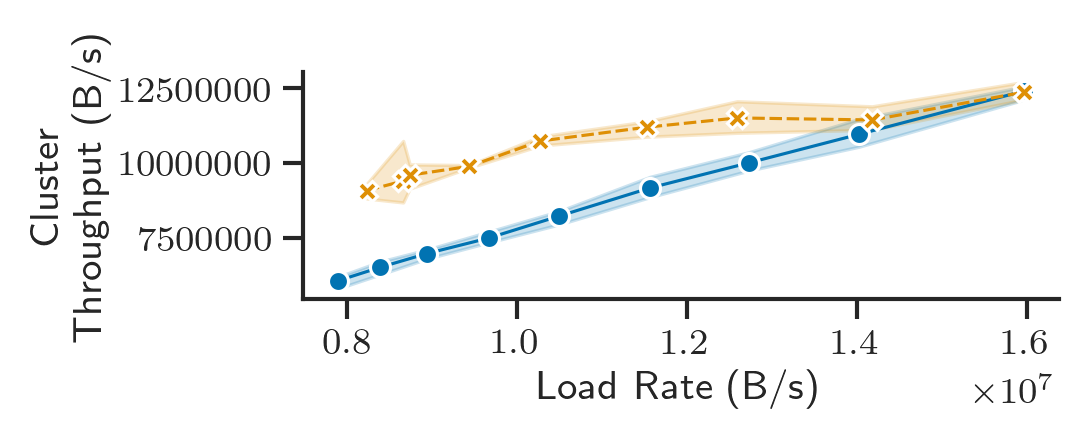

Plotting metric mean_demand_total_throughput -> min=5602291.498954506 | max=12159577.127693169 | mean=7975190.581278986


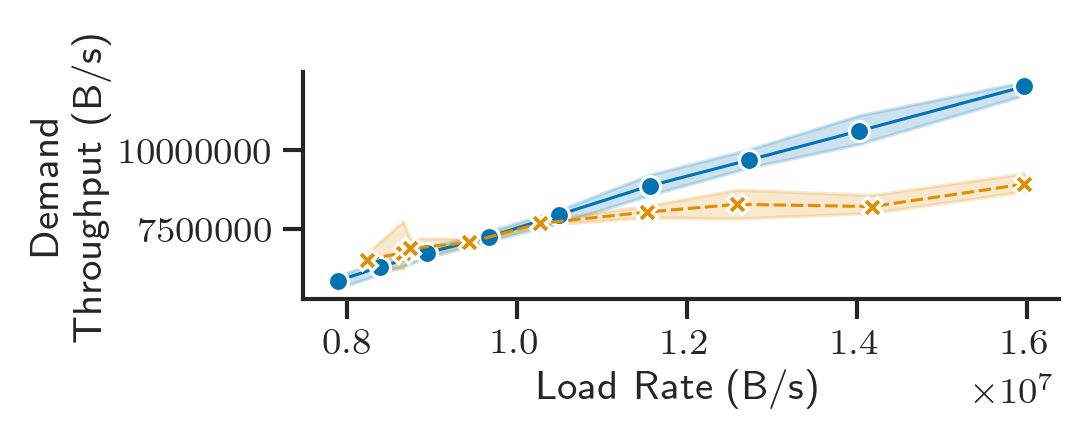

Plotting metric blocking_rate -> min=0.19155844155844157 | max=0.4171656686626746 | mean=0.25804516439182534


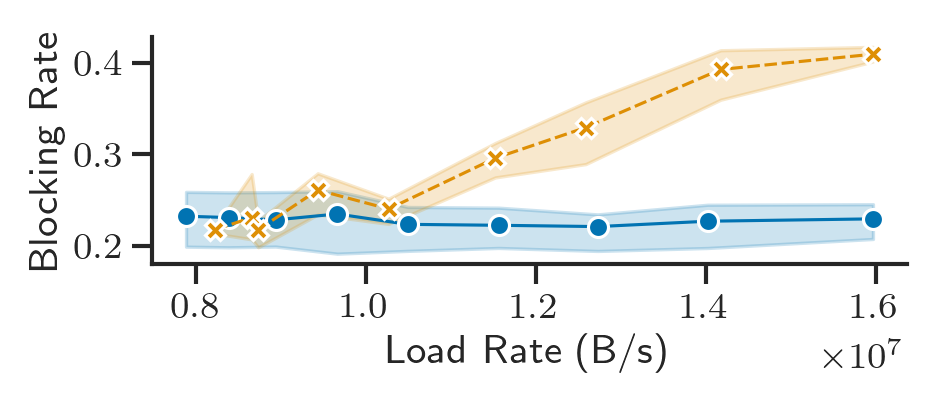

Plotting metric job_completion_time -> min=7502.782527954105 | max=28478.85446428572 | mean=17767.497027927257


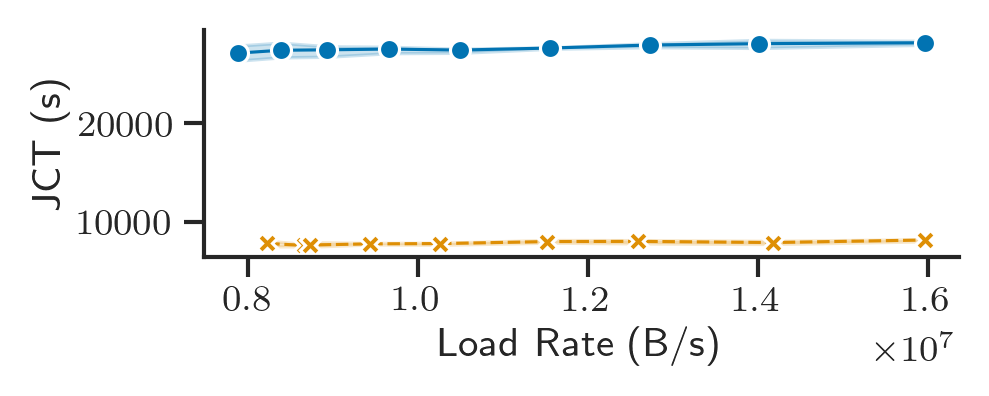

In [185]:
metrics = ['mean_cluster_throughput', 'mean_demand_total_throughput', 'blocking_rate']
for metric in metrics:
    lineplot(df=episode_stats_df, metric=metric)
    
metrics = ['job_completion_time']
for metric in metrics:
    lineplot(df=episode_completion_stats_df, metric=metric)